In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
import SenseEmb

In [4]:
skv = SenseEmb.SenseKeyedVectors.load_from_kv("../data/sense-emb-asbc5-600k-d50.kv")

In [5]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.linalg as la
from tqdm.auto import tqdm
import json

In [6]:
## get cwn instance from SKV
cwn = skv.cwn

In [7]:
def entropy(x, norm=True):
    if len(x) == 1:
        return 0
    x = np.array(x)
    p = x/x.sum()
    pz = p[p > 0]
    E = -(pz * np.log2(pz)).sum()
    if norm:
        return E / np.log2(len(x))
    else:
        return E

In [8]:
def gram_vol(vecs, log=False):
    gram_det = la.det(vecs.T.dot(vecs))
    vol = np.sqrt(gram_det)
    if log:
        return np.log(vol)
    else:
        return vol

def get_n_simplex(n, s=1):
    coords = np.zeros(shape=(n+1, n))
    for i in range(n):
        coords[i][i] = 1
    coords[n] = (1-np.sqrt(n+1))/n * np.ones(n)
    return (coords-coords.mean(0))/np.sqrt(2) * s

def compute_sense_volume(word):
    try:
        sdata = skv.make_sense_vectors(word)    
    except ValueError:
        return {}        
    
    sense_vecs = sdata.sense_vecs
    n_sense, k = sense_vecs.shape
    s_idx = np.argmax(sdata.sense_freqs)
    
    simplex = get_n_simplex(k, s=1) + sense_vecs[s_idx, :]    
    svecs = np.vstack([sense_vecs, simplex])            

    ori = svecs[s_idx, :]
    osvecs = svecs - ori
    Z = la.norm(svecs, axis=0).prod()
    
    vol_svecs = gram_vol(svecs)
    vol_osvecs = gram_vol(osvecs)
    vol_onsvecs = vol_osvecs / Z

    return dict(n_sense=n_sense, 
                V_raw=vol_svecs, 
                V_cen=vol_osvecs,  
                V_cennorm = vol_onsvecs)

In [9]:
def make_word_sense_indices(target_word):
    NA = np.nan
        
    ## find sense counts
    senses = cwn.find_all_senses(target_word)
    n_sense = len(senses)
    
    if n_sense == 0:
        return {}
    log_n_sense = np.log(n_sense)

    ## find sense frequency
    sense_freqs = [skv.query_sense_freq(sense_x) for sense_x in senses]
    sense_freqs = np.array(sense_freqs)
    n_tagged = (sense_freqs > 0).sum()
    sfreq_sum = sense_freqs.sum()
        
    sfreq_std = NA
    sfreq_ent = NA
    sfreq_ent_norm = NA
    sfreq_max = NA
    if sfreq_sum > 0:
        sfreq_std = sense_freqs.std()
        sfreq_ent = entropy(sense_freqs, norm=False)
        sfreq_ent_norm = entropy(sense_freqs, norm=True)
        sfreq_max = sense_freqs.max()

    ## compute sense volume       
    
    sense_vols = {}
    if n_tagged >= 1:
        sense_vols = compute_sense_volume(target_word)

    return dict(
        word=target_word,
        n_sense=n_sense, log_n_sense=log_n_sense,
        n_tagged=n_tagged, 
        sfreq_sum=sfreq_sum, sfreq_max=sfreq_max, sfreq_std=sfreq_std,
        sfreq_ent=sfreq_ent, sfreq_ent_norm=sfreq_ent_norm,
        vol_raw=np.log(sense_vols.get("V_raw", np.nan)),
        vol_cen=np.log(sense_vols.get("V_cen", np.nan)),
        vol_cennorm=np.log(sense_vols.get("V_cennorm", np.nan))
    )



In [10]:
make_word_sense_indices("開")

{'word': '開',
 'n_sense': 86,
 'log_n_sense': 4.454347296253507,
 'n_tagged': 62,
 'sfreq_sum': 1070,
 'sfreq_max': 118,
 'sfreq_std': 22.315707603412335,
 'sfreq_ent': 4.9563708295774775,
 'sfreq_ent_norm': 0.7712677610972846,
 'vol_raw': -0.09990546426528835,
 'vol_cen': -1.6450232854733435,
 'vol_cennorm': -22.86749952666934}

## Data loop

In [11]:
lemmas = list(cwn.get_all_lemmas().keys())
print(len(lemmas))

26549


In [ ]:
# sampled = np.random.choice(np.array(lemmas), size=100, replace=False)
sampled = lemmas
sense_indices = []
for word in tqdm(sampled):
    result = make_word_sense_indices(word)
    if result:
        sense_indices.append(result)

In [ ]:
import pandas as pd
sense_idx_frame = pd.DataFrame(sense_indices)
sense_idx_frame.to_csv("../data/sense_tagged_indices.csv", index=False)

### Load from cache

In [13]:
import pandas as pd
sense_idx_frame = pd.read_csv("../data/sense_tagged_indices.csv", index_col=None)

In [14]:
sense_idx_frame.corr()

,n_sense,log_n_sense,n_tagged,sfreq_sum,sfreq_max,sfreq_std,sfreq_ent,sfreq_ent_norm,vol_raw,vol_cen,vol_cennorm
n_sense,1.000000,0.827544,0.878716,0.123124,0.105206,0.105879,0.710022,0.347477,0.866602,0.859274,0.004104
log_n_sense,0.827544,1.000000,0.709229,0.110513,0.098084,0.131160,0.798972,0.541441,0.744531,0.750374,0.038798
n_tagged,0.878716,0.709229,1.000000,0.168729,0.156098,0.153180,0.777887,0.463382,0.980501,0.972689,-0.006423
sfreq_sum,0.123124,0.110513,0.168729,1.000000,0.956260,0.892478,0.100643,0.051998,0.188426,0.191148,0.006744
sfreq_max,0.105206,0.098084,0.156098,0.956260,1.000000,0.950203,0.071766,0.030428,0.187087,0.191346,0.010249
sfreq_std,0.105879,0.131160,0.153180,0.892478,0.950203,1.000000,0.087613,0.054370,0.187005,0.193144,0.017368
sfreq_ent,0.710022,0.798972,0.777887,0.100643,0.071766,0.087613,1.000000,0.821587,0.794564,0.796066,0.021700
sfreq_ent_norm,0.347477,0.541441,0.463382,0.051998,0.030428,0.054370,0.821587,1.000000,0.481464,0.486733,0.020282
vol_raw,0.866602,0.744531,0.980501,0.188426,0.187087,0.187005,0.794564,0.481464,1.000000,0.998955,0.018179
vol_cen,0.859274,0.750374,0.972689,0.191148,0.191346,0.193144,0.796066,0.486733,0.998955,1.000000,0.023412


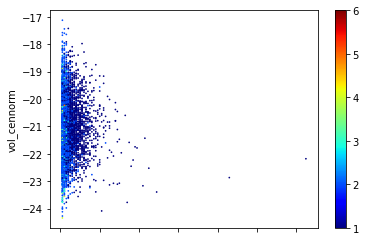

In [15]:
sense_idx_frame.plot.scatter("n_sense", "vol_cennorm", c=sense_idx_frame.word.str.len(), cmap="jet", s=0.5)

In [87]:
sense_idx_frame.loc[sense_idx_frame.n_sense==1, :].sort_values("vol_cennorm")

,word,n_sense,log_n_sense,n_tagged,sfreq_sum,sfreq_max,sfreq_std,sfreq_ent,sfreq_ent_norm,vol_raw,vol_cen,vol_cennorm
1067,冥冥之中,1,0.0,1,2,2.0,0.0,0.0,0.0,-15.001699,-17.32868,-24.338258
761,個體,1,0.0,1,116,116.0,0.0,0.0,0.0,-15.001699,-17.32868,-24.269512
4638,棒球,1,0.0,1,111,111.0,0.0,0.0,0.0,-15.001699,-17.32868,-24.113325
1349,勞工,1,0.0,1,512,512.0,0.0,0.0,0.0,-15.001699,-17.32868,-24.011725
7650,買方,1,0.0,1,27,27.0,0.0,0.0,0.0,-15.001699,-17.32868,-23.997422
...,...,...,...,...,...,...,...,...,...,...,...,...
8975,鷺,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8977,鸝,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8988,黎,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9001,點數,1,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Merge Dataset

### CLP
Tse, C. S., Yap, M. J., Chan, Y. L., Sze, W. P., Shaoul, C., & Lin, D. (2017). The Chinese Lexicon Project: A megastudy of lexical decision performance for 25,000+ traditional Chinese two-character compound words. Behavior Research Methods, 49(4), 1503-1519.
https://pubmed.ncbi.nlm.nih.gov/27734329/

In [17]:
CLP_data = pd.read_excel("../data/Tse-2017-Chinese-lexicon-project.xlsx", sheet_name=0)

In [18]:
CLP_data.head()

,Word_Trad,Word_Sim,Ntrials,Acc,RT,RT-SE,RT-SD,zRT,Stroke-1,Stroke-2,...,Google-freq-C1,Google-freq-C2,C&B-Subtitle-raw-W,C&B-Subtitle-CD-W,SS&M-W,Da-News-W,Da-Fiction-W,Google-freq-W,ST-C1,ST-C2
0,一刀,一刀,29,0.94,677.79,26.09,140.53,0.12,1,2,...,34200000,2290000,NaN,NaN,NaN,45.0,268.0,313000,-0.43,0.15
1,一口,一口,27,0.85,698.89,35.82,186.11,0.24,1,3,...,34200000,2710000,NaN,NaN,8057.0,224.0,3315.0,792000,-0.77,-0.05
2,一分,一分,32,0.97,628.78,39.69,224.52,-0.23,1,4,...,34200000,11700000,952.0,675.0,14150.0,NaN,773.0,533000,-0.43,-0.03
3,一切,一切,32,1.00,560.91,17.35,98.15,-0.61,1,4,...,34200000,1530000,21709.0,5326.0,7873937.0,1572.0,6903.0,2030000,-0.84,-1.28
4,一心,一心,29,0.88,646.34,28.99,156.10,0.03,1,4,...,34200000,11900000,137.0,128.0,196888.0,NaN,NaN,452000,-0.86,-0.62


In [25]:
CLP_data["C1"] = CLP_data["Word_Trad"].str.slice(0, 1)
CLP_data["C2"] = CLP_data["Word_Trad"].str.slice(1, 2)

In [54]:
CLP_merged = CLP_data.merge(sense_idx_frame, left_on="Word_Trad", right_on="word")\
                     .merge(sense_idx_frame, left_on="C1", right_on="word", suffixes=("_W", "_C1"))\
                     .merge(sense_idx_frame, left_on="C2", right_on="word", suffixes=(False, "_C2"))
CLP_merged.columns.values[-12:] = CLP_merged.columns.values[-12:] + "_C2"
CLP_merged.drop(columns=["word_W", "word_C1", "word_C2"], inplace=True)

In [55]:
CLP_merged.head()

,Word_Trad,Word_Sim,Ntrials,Acc,RT,RT-SE,RT-SD,zRT,Stroke-1,Stroke-2,...,log_n_sense_C2,n_tagged_C2,sfreq_sum_C2,sfreq_max_C2,sfreq_std_C2,sfreq_ent_C2,sfreq_ent_norm_C2,vol_raw_C2,vol_cen_C2,vol_cennorm_C2
0,一切,一切,32,1.00,560.91,17.35,98.15,-0.61,1,4,...,2.890372,9,90,45.0,10.219806,2.417606,0.579772,-11.851237,-13.882482,-21.767178
1,急切,急切,32,0.97,655.06,24.00,135.78,0.05,9,4,...,2.890372,9,90,45.0,10.219806,2.417606,0.579772,-11.851237,-13.882482,-21.767178
2,迫切,迫切,29,0.94,621.24,24.09,129.71,-0.17,9,4,...,2.890372,9,90,45.0,10.219806,2.417606,0.579772,-11.851237,-13.882482,-21.767178
3,密切,密切,29,1.00,626.93,27.74,149.37,-0.29,11,4,...,2.890372,9,90,45.0,10.219806,2.417606,0.579772,-11.851237,-13.882482,-21.767178
4,悲切,悲切,23,0.73,753.48,47.97,230.05,0.47,12,4,...,2.890372,9,90,45.0,10.219806,2.417606,0.579772,-11.851237,-13.882482,-21.767178


In [60]:
CLP_merged.to_csv("CLP_sense_indices_2char.csv", index=False, encoding="UTF-8")
CLP_merged.shape

(3712, 63)

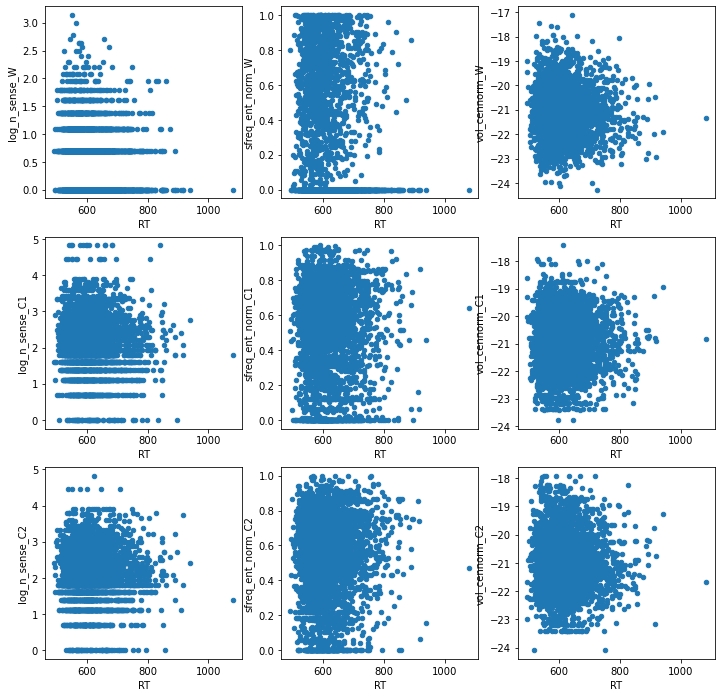

In [57]:
_, axes = plt.subplots(3, 3, figsize=(12, 12))
CLP_merged.plot.scatter("RT", "log_n_sense_W", ax=axes[0][0])
CLP_merged.plot.scatter("RT", "sfreq_ent_norm_W", ax=axes[0][1])
CLP_merged.plot.scatter("RT", "vol_cennorm_W", ax=axes[0][2])
CLP_merged.plot.scatter("RT", "log_n_sense_C1", ax=axes[1][0])
CLP_merged.plot.scatter("RT", "sfreq_ent_norm_C1", ax=axes[1][1])
CLP_merged.plot.scatter("RT", "vol_cennorm_C1", ax=axes[1][2])
CLP_merged.plot.scatter("RT", "log_n_sense_C2", ax=axes[2][0])
CLP_merged.plot.scatter("RT", "sfreq_ent_norm_C2", ax=axes[2][1])
CLP_merged.plot.scatter("RT", "vol_cennorm_C2", ax=axes[2][2])

### MELD-SCH
MELD-SCH (MEgastudy of Lexical Decision in Simplified CHinese)  
https://link.springer.com/article/10.3758%2Fs13428-017-0944-0

In [16]:
MELD_data = pd.read_excel("../data/Tsang-2018-MELD-SCH.xlsx", sheet_name=0)

In [74]:
import opencc
converter = opencc.OpenCC('s2t.json')
MELD_data["word_trad"] = [converter.convert(x) for x in MELD_data.word]

In [75]:
MELD_data.iloc[1000:1010, :]

,id,word,lexicality,N,RT,RTSD,zRT,zRTSD,ERR,length,...,C3pr2,C3pr3,C3pr4,C3pr5,C4pr1,C4pr2,C4pr3,C4pr4,C4pr5,word_trad
1000,101001,骁,1,35,919.143429,310.844904,0.267824,0.845023,12.500000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,驍
1001,101002,骂,1,41,673.186098,239.162570,-0.546532,0.707942,0.000000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,罵
1002,101003,骊,1,28,921.380357,418.883973,0.211151,1.010271,30.000000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,驪
1003,101004,骐,1,27,993.927407,444.578493,0.481393,1.158402,30.769231,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,騏
1004,101005,骛,1,31,962.945161,311.035287,0.259986,0.813573,22.500000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,騖
1005,101006,鲀,1,11,1029.396364,239.121121,0.651036,1.110402,72.500000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,魨
1006,101007,鲍,1,39,829.343333,216.207607,0.005994,0.675650,4.878049,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,鮑
1007,101008,鲛,1,35,975.524857,328.562286,0.569384,1.133779,14.634146,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,鮫
1008,101009,鲳,1,11,1307.690909,487.097769,1.547204,1.416478,72.500000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,鯧
1009,101010,鳐,1,24,1083.866250,499.537547,0.811604,1.421843,42.857143,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,鰩


In [76]:
MELD_merged = MELD_data.merge(sense_idx_frame, left_on="word_trad", right_on="word")
MELD_merged.to_csv("MELD_sense_indices.csv", index=False)

In [77]:
MELD_merged.shape

(2935, 67)

<AxesSubplot:xlabel='RT', ylabel='vol_cennorm'>

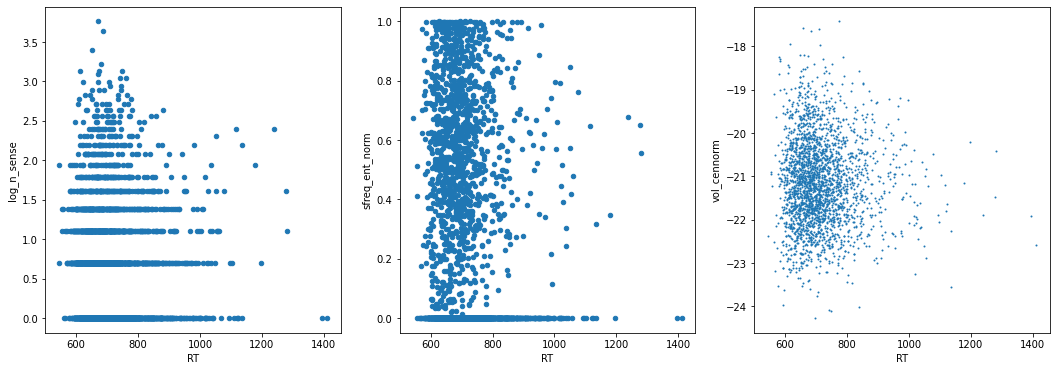

In [78]:
_, axes = plt.subplots(1, 3, figsize=(18, 6))
MELD_merged.plot.scatter("RT", "log_n_sense", ax=axes[0])
MELD_merged.plot.scatter("RT", "sfreq_ent_norm", ax=axes[1])
MELD_merged.plot.scatter("RT", "vol_cennorm", s=1, ax=axes[2])

### Chinese Character Naming (Lee)

In [79]:
naming_data = pd.read_excel("../data/Lee-naming-data.xlsx", sheet_name=0)

In [80]:
naming_data.head()

,Character,zhuyin,Phonetic Component,Semantic Component,Frequency,Consistency (type),Consistency (token),Regularity,Homophone Density,Phonetic Combinability,Semantic Combinability,Stroke,Familiarity,Semantic Ambiguity Rating,NC1,NC2,Naming Acc,Naming RT
0,仃,ㄉㄧㄥ,丁,,6,0.7500,0.671134,1,11,11,150,4,2.225,1.1538,0,0,0.80,899
1,仆,ㄆㄨ,卜,,13,0.3333,0.253145,1,7,5,150,4,3.175,1.3077,1,0,0.85,812
2,仍,ㄖㄥˊ,乃,,13377,0.5000,0.524556,0,1,4,150,4,5.950,1.3846,2,1,0.90,719
3,他,ㄊㄚ,也,,49316,0.5000,0.507360,0,12,8,150,5,6.325,1.9231,12,3,1.00,596
4,仗,ㄓㄤˋ,丈,,209,1.0000,1.000000,1,12,2,150,5,4.725,2.2308,2,8,0.85,659


In [81]:
naming_merged = naming_data.rename(columns={"Naming RT": "RT"}).merge(sense_idx_frame, left_on="Character", right_on="word")
naming_merged.to_csv("naming_sense_indices.csv", index=False)
naming_merged.shape

(1398, 30)

<AxesSubplot:xlabel='RT', ylabel='vol_cennorm'>

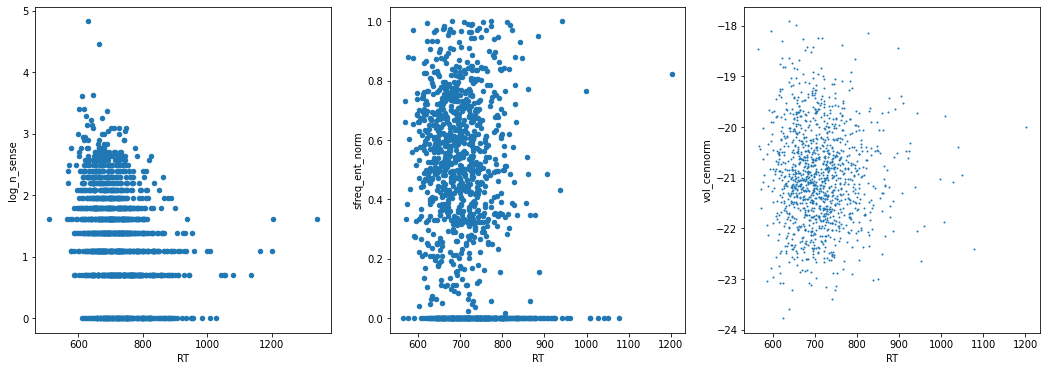

In [82]:
_, axes = plt.subplots(1, 3, figsize=(18, 6))
naming_merged.plot.scatter("RT", "log_n_sense", ax=axes[0])
naming_merged.plot.scatter("RT", "sfreq_ent_norm", ax=axes[1])
naming_merged.plot.scatter("RT", "vol_cennorm", s=1, ax=axes[2])